**Chapter04 | Summary |**  
  
이상값과 예상치 못한 값이 모두 오류인 것은 아니지만, 극단적인 값은 분석에 영향을 끼친다  
이러한 이슈는 데이터의 부분집합을 다룰 때 더 극명해진다 (1. 작은 크기의 샘플이라서, 2. 이변량/다면량 관계에 따라 의미가 달라져서)  
이 챕터에서는 이러한 복잡성을 고려하면서 `이상값`, `예상치 못한 값`, `누락값`을 감지하는 전략 세우기를 학습한다.  
* STEP🔍  
    1. 누락값 찾기(missing values)  
    2. 변수가 1개인 이상값 식별하기(outliers univariate)
    3. 이변량 관계의 이상값과 예상치 못한 값 식별하기(outliers bivariate) 
    4. 부분집합을 이용해 변수 간의 논리적 불일치를 찾기(conditional selection)   
      
        
* TIP📍  
         1) bool indexing(행 선택) & index alignment(열 선택)를 활용한 데이터 부분집합 선택
            ⭐df.loc[varsmisscnt>=3, ['location']+demovars]  
              (여기서 varsmisscnt는 df[demovars].isnull().sum(axis=1)임)
         2) 컬럼 목록을 반복문에 사용할 때
            ⭐for col in df.columns[1:]
         3) 컬럼(변수)에 값을 할당하기 - 변수가 이전에 가졌던 값을 수정해 할당하는 일에 쓸 수 있음
            ⭐odf = df.assign(새로운변수명 = df['할당하려는 칼럼명']+(연산식))
            

# missing values 
**누락값 찾기**  
분석을 시작하기 전에 (1) 변수별로 누락값이 얼마나 있고 누락된 이유는 뭔지, (2) 주요 변수 여러개가 누락된 행이 어느 것인지에 대한 정보를 얻고  
누락값을 다루는 전략으로 '누락값 대치(imputation)'를 실습해본다  



In [45]:
# 0. set groups of columns
totvars = ['location','total_cases','total_deaths','total_cases_pm','total_deaths_pm'] # 사례 열 
demovars = ['population','pop_density','median_age','gdp_per_capita','hosp_beds'] # 인구통계 열

In [34]:
# 1. demo group - missing values of columns
covidtotals[demovars].isnull().sum(axis=0)

population         0
pop_density       12
median_age        24
gdp_per_capita    28
hosp_beds         46
dtype: int64

In [35]:
# 2. demo group - missing values of rows
demoVarsMissCnt = covidtotals[demovars].isnull().sum(axis=1)
type(demoVarsMissCnt) # = pandas series
demoVarsMissCnt.value_counts()

0    156
1     24
2     12
3     10
4      8
dtype: int64

In [36]:
# 3. demo group - three or more missing values in a row
covidtotals.loc[demoVarsMissCnt>=3, ['location'] + demovars].head(5)

,location,population,pop_density,median_age,gdp_per_capita,hosp_beds
3,Andorra,77265.0,163.755,NaN,NaN,NaN
5,Anguilla,15002.0,NaN,NaN,NaN,NaN
24,Bonaire Sint Eustatius and Saba,26221.0,NaN,NaN,NaN,NaN
28,British Virgin Islands,30237.0,207.973,NaN,NaN,NaN
64,Faeroe Islands,48865.0,35.308,NaN,NaN,NaN


In [37]:
# 4. case group - missing values of columns
covidtotals[totvars].isnull().sum(axis=0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     1
total_deaths_pm    1
dtype: int64

In [38]:
# 5. case group - missing values of rows
totVarsMissCnt = covidtotals[totvars].isnull().sum(axis=1)
totVarsMissCnt.value_counts()

0    209
2      1
dtype: int64

In [39]:
# 6. case group - more than 0 missing values in a row
covidtotals.loc[totVarsMissCnt>0]

,iso_code,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
87,HKG,2020-05-26,Hong Kong,0,0,NaN,NaN,7496988.0,7039.714,44.8,56054.92,NaN


In [41]:
# 7. missing values imputation
covidtotals.total_cases_pm.fillna(covidtotals.total_cases/(covidtotals.population/1000000), inplace=True)
covidtotals.total_deaths_pm.fillna(covidtotals.total_deaths/(covidtotals.population/1000000), inplace=True)
covidtotals[totvars].isnull().sum(axis=0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     0
total_deaths_pm    0
dtype: int64

# outliers univariate  
**변수가 1개인 이상값 식별하기**  
이상값(outlier)을 식별하려면 변수의 분포를 먼저 이해해야 한다.  
두 가지 라이브러리를 사용해서, 변수가 문제가 될 정도로 범위를 벗어났는지 식별한다.

In [58]:
# 1. cases information > dataframe
covidtotalsOnly = covidtotals.loc[:, totvars]
covidtotalsOnly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,210.0,210.0,210.0,210.0
mean,"29,216.1","1,770.7","1,355.4",55.7
std,"136,397.8","8,705.6","2,625.3",144.8
min,0.0,0.0,0.0,0.0
25%,175.8,4.0,92.5,0.9
50%,"1,242.5",25.5,280.9,6.2
75%,"10,117.0",241.2,"1,801.4",31.8
max,"1,790,191.0","104,383.0","19,771.3","1,237.6"


In [59]:
# 2. check quantile
covidtotalsOnly.quantile(np.arange(0.0, 1.1, 0.1))

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,0.0,0.0,0.0,0.0
0.1,22.9,0.0,18.0,0.0
0.2,105.2,2.0,56.3,0.4
0.3,302.0,6.7,115.4,1.7
0.4,762.0,12.0,214.0,4.0
0.5,"1,242.5",25.5,280.9,6.2
0.6,"2,514.6",54.6,544.0,12.2
0.7,"6,959.8",137.2,"1,071.2",25.9
0.8,"16,847.2",323.2,"2,206.3",50.0
0.9,"46,513.1","1,616.9","3,765.1",138.9


In [56]:
# 3. chcek skewness
covidtotalsOnly.skew() # 왜도 : 얼마나 대칭적인지

total_cases       11
total_deaths       9
total_cases_pm     4
total_deaths_pm    5
dtype: float64

In [60]:
# 4. check kurtosis 
covidtotalsOnly.kurtosis() # 첨도 : 분포 꼬리가 얼마나 굵은지

total_cases       135.0
total_deaths       95.7
total_cases_pm     25.2
total_deaths_pm    27.2
dtype: float64

In [65]:
# 5. test normality 
def testnorm(var, df):
    stat, p = scistat.shapiro(df[var]) # scipy의 샤피로윌크검정 사용
    return p 

# p-value < 0.05 : 95% 수준에서 정규분포 귀무가설 기각
testnorm('total_cases', covidtotalsOnly) # 모두 귀무가설 채택 : 정규적이지 않음
testnorm('total_deaths', covidtotalsOnly)
testnorm('total_cases_pm', covidtotalsOnly)
testnorm('total_deaths_pm', covidtotalsOnly)

1.361060423265974e-25

Text(0.5, 1.0, 'QQ plot of Total Cases')

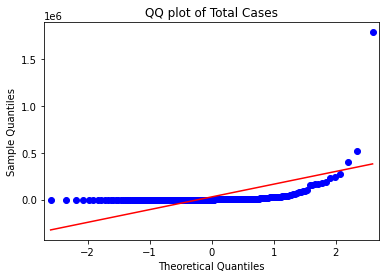

In [70]:
# 6. normality visualization > qqplot
# QQ plot? 정규 분위수-분위수 그림, 직선(분포가 정규일 경우) 모습과 비교하여 볼 수 있다
sm.qqplot(covidtotalsOnly[['total_cases']].sort_values(['total_cases']), line='s')
plt.title('QQ plot of Total Cases')

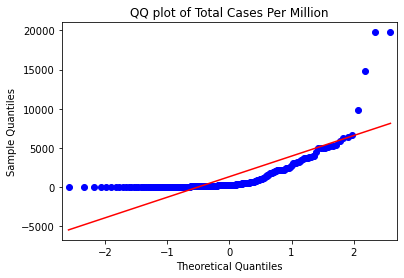

In [72]:
sm.qqplot(covidtotalsOnly[['total_cases_pm']].sort_values(['total_cases_pm']), line='s')
plt.title('QQ plot of Total Cases Per Million')
plt.show()

In [74]:
# 7. outliers range ('총 확진자 수' 이상값 범위)
thirdq, firstq = covidtotalsOnly.total_cases.quantile(0.75), covidtotalsOnly.total_cases.quantile(0.25)
interQuartileRange = 1.5*(thirdq-firstq)
outlierhigh, outlierlow = interQuartileRange+thirdq, firstq+interQuartileRange
print(outlierlow, outlierhigh, sep='<-->')

15087.625<-->25028.875


In [100]:
# 8. write outliers on dataframe 
def getoutliers():
    dfOut = pd.DataFrame(columns=covidtotals.columns, data=None) # 컬럼명만 있는 비어있는 dataframe 만들기
    for col in covidtotalsOnly.columns[1:]:
        thirdq, firstq = covidtotalsOnly[col].quantile(0.75), covidtotalsOnly[col].quantile(0.25)
        interQuartileRange = 1.5*(thirdq-firstq)
        outlierhigh, outlierlow = interQuartileRange+thirdq, interQuartileRange+firstq
        df = covidtotals.loc[(covidtotals[col]>outlierhigh)|(covidtotals[col]<outlierlow)] # col에 대해 이상값 임계치를 넘긴 행 모두 선택 > dataframe화
        df = df.assign(varname=col, threshlow=outlierlow, threshhigh=outlierhigh) # 어떤 col에 대해 문제되는 행으로 뽑혔는지, 문제삼은 하상한선은 뭔지 > columns 추가
        dfOut = pd.concat([dfOut, df]) # 위아래 병합에 사용하는 concat 함수 사용 > dfOut 아래에 df(이상값만 뽑은 dataframe) 더하기
    return dfOut

outliers = getoutliers()
outliers.varname.value_counts()

total_deaths       205
total_cases        198
total_deaths_pm    194
total_cases_pm     193
Name: varname, dtype: int64

In [84]:
outliers.to_excel('views/outlierscases.xlsx')

In [113]:
# 9. details about outliers ('백만명당 확진자 수' 이상값 상세보기)
outliers.loc[outliers.varname=='total_cases_pm',['location','total_cases_pm','pop_density','gdp_per_capita']].\
                                sort_values(['total_cases_pm'], ascending=False) # total_cases_pm 이상값 모아보기

,location,total_cases_pm,pop_density,gdp_per_capita
SMR,San Marino,"19,771.3",556.7,"56,861.5"
QAT,Qatar,"19,753.1",227.3,"116,935.6"
VAT,Vatican,"14,833.1",nan,nan
AND,Andorra,"9,888.0",163.8,nan
BHR,Bahrain,"6,698.5","1,935.9","43,290.7"
...,...,...,...,...
AGO,Angola,2.6,23.9,"5,819.5"
LAO,Laos,2.6,29.7,"6,397.4"
LSO,Lesotho,0.9,73.6,"2,851.2"
PNG,Papua New Guinea,0.9,18.2,"3,823.2"


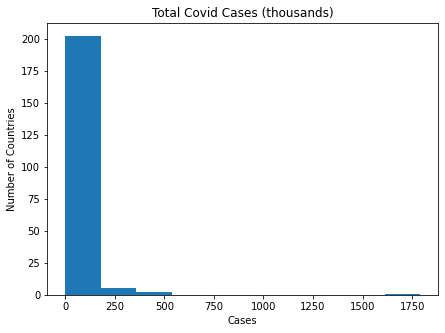

In [131]:
# 10. histogram ('총 확진자 수' 시각화)
plt.figure(figsize=(7,5))
plt.hist(covidtotalsOnly['total_cases']/1000, bins=10)
plt.title('Total Covid Cases (thousands)')
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.show()

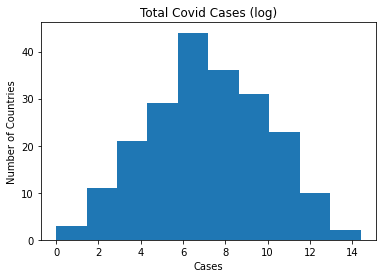

In [128]:
# 11. apply log > histogram
covidlogs = covidtotalsOnly.copy()

for col in covidtotalsOnly.columns[1:]:
    covidlogs[col] = np.log1p(covidlogs[col])

plt.hist(covidlogs['total_cases'], bins=10)
plt.title('Total Covid Cases (log)')
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.show()

# outliers bivariate  
**이변량 관계의 이상값과 예상치 못한 값 식별하기**    
극단값이 아니어도 예상치 못한 값일 수 있다. 한 변수의 어떤 값은 다른 변수가 특정한 값일 경우에만 예상치 못한 값이 되는 경우도 있다.  
(e.g. A 지점에서 새를 52회 목격, A 지점 평균 목격횟수가 10회라면 평소보다 너무 높은 값)  
이 장에서는 변수들 간 관계를 조사하고 > 이상값 & 예상치 못한 값 탐지 연습


In [136]:
# 1. correlation check
covidtotals.corr(method='pearson')
# # total cases <-> total deaths : 매우 높은 상관관계 (0.93)
# # total cases per million <-> total deaths per million : 상당한 상관관계 (0.59)
# # total cases per million <-> gdp per capita : 강한 상관관계 (0.65)

,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
total_cases,1.00,0.93,0.18,0.25,0.27,-0.03,0.16,0.19,0.03
total_deaths,0.93,1.00,0.18,0.39,0.21,-0.03,0.21,0.20,0.02
total_cases_pm,0.18,0.18,1.00,0.59,-0.06,0.11,0.31,0.65,0.08
total_deaths_pm,0.25,0.39,0.59,1.00,-0.01,0.03,0.39,0.38,0.12
population,0.27,0.21,-0.06,-0.01,1.00,-0.02,0.02,-0.06,-0.04
pop_density,-0.03,-0.03,0.11,0.03,-0.02,1.00,0.18,0.32,0.31
median_age,0.16,0.21,0.31,0.39,0.02,0.18,1.00,0.65,0.66
gdp_per_capita,0.19,0.20,0.65,0.38,-0.06,0.32,0.65,1.00,0.30
hosp_beds,0.03,0.02,0.08,0.12,-0.04,0.31,0.66,0.30,1.00


In [137]:
#  2-1. (CROSSTABLE) out of expectation : between total cases and total deaths 
covidtotalsOnly = covidtotals.loc[:, totvars]
covidtotalsOnly['total_cases_q'] = pd.qcut(covidtotalsOnly['total_cases'], labels=['very low','low','medium','high','very high'], q=5, precision=0)
covidtotalsOnly['total_deaths_q'] = pd.qcut(covidtotalsOnly['total_deaths'], labels=['very low','low','medium','high','very high'], q=5, precision=0)
pd.crosstab(covidtotalsOnly.total_cases_q, covidtotalsOnly.total_deaths_q)

total_deaths_q,very low,low,medium,high,very high
total_cases_q,,,,,
very low,34,7,1,0,0
low,12,19,10,1,0
medium,1,13,15,13,0
high,0,0,12,24,6
very high,0,0,2,4,36


In [138]:
# 2-2. (CROSSTABLE) out of expectation - detail
covidtotals.loc[(covidtotalsOnly.total_cases_q=='very high') & (covidtotalsOnly.total_deaths_q=='medium')]

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,,,,,
QAT,2020-06-01,Qatar,56910,38,"19,753.15",13.19,"2,881,060.00",227.32,31.90,"116,935.60",1.20
SGP,2020-06-01,Singapore,34884,23,"5,962.73",3.93,"5,850,343.00","7,915.73",42.40,"85,535.38",2.40


In [139]:
covidtotals.loc[(covidtotalsOnly.total_cases_q=='low') & (covidtotalsOnly.total_deaths_q=='high')]

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,,,,,
YEM,2020-06-01,Yemen,323,80,10.83,2.68,"29,825,968.00",53.51,20.30,"1,479.15",0.70


In [140]:
covidtotals.hosp_beds.mean()

3.012670731707318

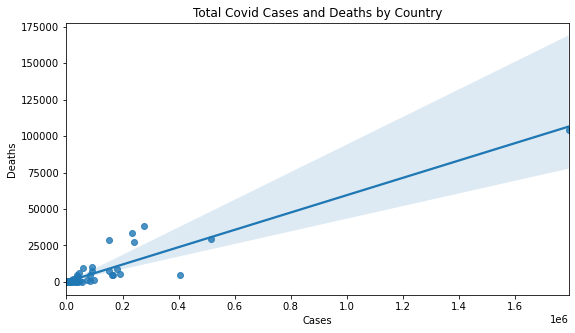

In [148]:
# 2-3. (Regression Plot) out of expectation - overviw
plt.figure(figsize=(9,5))
ax = sns.regplot(x='total_cases', y='total_deaths', data=covidtotals) # 총 사망자 - 총 확진자 산점도
ax.set(xlabel='Cases', ylabel='Deaths', title='Total Covid Cases and Deaths by Country')
plt.show()

In [149]:
# 2-4. (Regression Plot) out of expectation - detail
covidtotals.loc[(covidtotals.total_cases<300000) & (covidtotals.total_deaths>20000)] 
# 회귀직선보다 눈에 띄게 위쪽에 있는 국가 = 확진자 수 대비 사망자가 비교적 많은 국가

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,,,,,
FRA,2020-06-01,France,151753,28802,"2,324.88",441.25,"65,273,512.00",122.58,42.00,"38,605.67",5.98
ITA,2020-06-01,Italy,233019,33415,"3,853.99",552.66,"60,461,828.00",205.86,47.90,"35,220.08",3.18
ESP,2020-05-31,Spain,239429,27127,"5,120.95",580.20,"46,754,783.00",93.11,45.50,"34,272.36",2.97
GBR,2020-06-01,United Kingdom,274762,38489,"4,047.40",566.97,"67,886,004.00",272.90,40.80,"39,753.24",2.54


In [150]:
covidtotals.loc[(covidtotals.total_cases>300000) & (covidtotals.total_deaths<20000)] 
# 회귀직선보다 눈에 띄게 아래 쪽에 있는 국가 = 확진자 수 대비 사망자가 비교적 적은 국가

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,,,,,
RUS,2020-06-01,Russia,405843,4693,"2,780.99",32.16,"145,934,460.00",8.82,39.60,"24,765.95",8.05


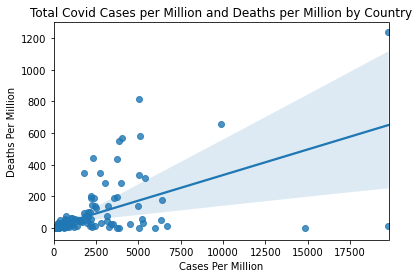

In [151]:
# 3-1. (Regression Plot) out of expectation : between 'total cases per million' and 'total deaths per million'
ax = sns.regplot(x='total_cases_pm', y='total_deaths_pm', data=covidtotals)
ax.set(xlabel='Cases Per Million', ylabel='Deaths Per Million', title='Total Covid Cases per Million and Deaths per Million by Country')
plt.show()

In [155]:
# 3-2. (Regression Plot) out of expectation - detail
covidtotals.loc[(covidtotals.total_cases_pm<7500) & (covidtotals.total_deaths_pm>250), ['location','total_cases_pm','total_deaths_pm']]

,location,total_cases_pm,total_deaths_pm
iso_code,,,
BEL,Belgium,"5,037.35",816.85
FRA,France,"2,324.88",441.25
IRL,Ireland,"5,060.96",334.56
IMN,Isle of Man,"3,951.45",282.25
ITA,Italy,"3,853.99",552.66
JEY,Jersey,"3,047.30",286.92
NLD,Netherlands,"2,710.38",347.60
SXM,Sint Maarten (Dutch part),"1,795.62",349.80
ESP,Spain,"5,120.95",580.20


In [157]:
covidtotals.loc[(covidtotals.total_cases_pm>5000) & (covidtotals.total_deaths_pm<50), ['location','total_cases_pm','total_deaths_pm']]

,location,total_cases_pm,total_deaths_pm
iso_code,,,
BHR,Bahrain,"6,698.47",11.17
GIB,Gibraltar,"5,016.18",0.00
ISL,Iceland,"5,292.31",29.30
KWT,Kuwait,"6,332.42",49.64
QAT,Qatar,"19,753.15",13.19
SGP,Singapore,"5,962.73",3.93
VAT,Vatican,"14,833.13",0.00


# conditional selection
**부분집합을 이용하여 변수 간 논리적 불일치를 찾기**  
특정 지점에서의 데이터 이슈를 확인하기 위하여, 논리적 불일치를 확인하는 것이 중요함. 특정 행의 값을 전체/특정 행의 부분집합과 비교할 수 있도록 아래의 도구를 학습  
    (1) 부분집합 도구 활용 (pandas loc, bool indexing)  
    (2) series & dataframe에 대한 요약 메서드

In [160]:
# 1. look around
nls97[['wageincome','highestgradecompleted','highestdegree']].head(3)

,wageincome,highestgradecompleted,highestdegree
personid,,,
100061,"12,500.00",13.00,2. High School
100139,"120,000.00",12.00,2. High School
100284,"58,000.00",7.00,0. None


In [162]:
nls97.loc[:, 'weeksworked12':'weeksworked17'].head(3).T # 연도별 근무 주 수

personid,100061,100139,100284
weeksworked12,40.00,52.00,0.00
weeksworked13,52.00,52.00,nan
weeksworked14,52.00,52.00,11.00
weeksworked15,52.00,52.00,52.00
weeksworked16,48.00,53.00,47.00
weeksworked17,48.00,52.00,0.00


In [164]:
nls97.loc[:, 'colenroct09':'colenroct14'].head(3).T # 연도별 대학 등록여부

personid,100061,100139,100284
colenroct09,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenrfeb10,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenroct10,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenrfeb11,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenroct11,3. 4-year college,1. Not enrolled,1. Not enrolled
colenrfeb12,3. 4-year college,1. Not enrolled,1. Not enrolled
colenroct12,3. 4-year college,1. Not enrolled,1. Not enrolled
colenrfeb13,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenroct13,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenrfeb14,1. Not enrolled,1. Not enrolled,1. Not enrolled


In [165]:
# 2. 임금소득 있으나 근무주가 없는 사람
nls97.loc[(nls97.weeksworked16==0) & nls97.wageincome>0, ['weeksworked16','wageincome']]

,weeksworked16,wageincome
personid,,
102625,0.00,"1,200.00"
109403,0.00,"5,000.00"
118704,0.00,"25,000.00"
130701,0.00,"12,000.00"
131151,0.00,"65,000.00"
...,...,...
957344,0.00,"90,000.00"
966697,0.00,"65,000.00"
969334,0.00,"5,000.00"


In [186]:
# 3. 4년제 대학에 등록한 적이 있는 사람
nls97.filter(like='colenr').apply(lambda x: x.str[0:1]=='3').head(2)

,colenrfeb97,colenroct97,colenrfeb98,colenroct98,colenrfeb99,colenroct99,colenrfeb00,...,colenroct14,colenrfeb15,colenroct15,colenrfeb16,colenroct16,colenrfeb17,colenroct17
personid,,,,,,,,,,,,,,,
100061,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
100139,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False


In [187]:
nls97.filter(like='colenr').apply(lambda x: x.str[0:1]=='3').any(axis=1).head(2) # 행 값에 True가 있는 personid에는 True가 출력되도록 하는 df.any(axis=1)

personid
100061     True
100139    False
dtype: bool

In [198]:
# 4. 대학원 등록 기록은 있지만, 학사 등록 데이터가 없는 사람
nobach = nls97.loc[nls97.filter(like='colenr').apply(lambda x: x.str[0:1]=='4').any(axis=1) &\
                   ~nls97.filter(like='colenr').apply(lambda x: x.str[0:1]=='3').any(axis=1), 'colenrfeb97':'colenroct17'] # '~'는 부정을 의미

len(nobach) # = 22명
nobach.head(3).T

personid,153051,154535,184721
colenrfeb97,NaN,NaN,NaN
colenroct97,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenrfeb98,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenroct98,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenrfeb99,1. Not enrolled,1. Not enrolled,1. Not enrolled
...,...,...,...
colenroct15,1. Not enrolled,4. Graduate program,NaN
colenrfeb16,1. Not enrolled,4. Graduate program,NaN
colenroct16,1. Not enrolled,4. Graduate program,NaN
colenrfeb17,1. Not enrolled,4. Graduate program,NaN


In [194]:
# 5. 학사 학위 이상이면서, 4년제 등록 기록이 없는 사람
nls97.highestdegree.value_counts(sort=False) # 값 내림차순으로 보지 않겠음

1. GED             1146
3. Associates       737
7. Professional     120
4. Bachelors       1673
6. PhD               54
2. High School     3667
5. Masters          603
0. None             953
Name: highestdegree, dtype: int64

In [197]:
no4yearEnrollment = nls97.loc[nls97.highestdegree.str[0:1].isin(['4','5','6','7']) &\
                              ~nls97.filter(like='colenr').apply(lambda x: x.str[0:1]=='3').any(axis=1),\
                              'colenrfeb97':'colenroct17']
len(no4yearEnrollment) # = 39명
no4yearEnrollment.head(3).T

personid,113486,118749,124616
colenrfeb97,1. Not enrolled,NaN,1. Not enrolled
colenroct97,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenrfeb98,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenroct98,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenrfeb99,1. Not enrolled,1. Not enrolled,1. Not enrolled
...,...,...,...
colenroct15,1. Not enrolled,1. Not enrolled,1. Not enrolled
colenrfeb16,NaN,1. Not enrolled,1. Not enrolled
colenroct16,NaN,1. Not enrolled,1. Not enrolled
colenrfeb17,NaN,1. Not enrolled,1. Not enrolled


In [202]:
# 6. 임금소득이 높은 사람
highwages = nls97.loc[nls97.wageincome > nls97.wageincome.mean()+(nls97.wageincome.std()*3), ['wageincome']]
highwages

,wageincome
personid,
131858,"235,884.00"
133619,"235,884.00"
151863,"235,884.00"
164058,"235,884.00"
164897,"235,884.00"
...,...
964406,"235,884.00"
966024,"235,884.00"
976141,"235,884.00"


In [207]:
# 7. 최근 연도에 근무주 수 변동이 큰 사람
workchanges = nls97.loc[~nls97.loc[:,'weeksworked12':'weeksworked16'].mean(axis=1).\
                        between(nls97.weeksworked17*0.5,nls97.weeksworked17*2)\
                        & ~nls97.weeksworked17.isnull(),\
                        'weeksworked12':'weeksworked17']
len(workchanges) # = 1160명
workchanges.head(7).T

personid,100284,101526,101718,101724,102228,102454,102625
weeksworked12,0.00,0.00,52.00,52.00,52.00,52.00,14.00
weeksworked13,nan,0.00,9.00,52.00,52.00,52.00,3.00
weeksworked14,11.00,0.00,0.00,52.00,17.00,7.00,52.00
weeksworked15,52.00,0.00,32.00,17.00,0.00,0.00,44.00
weeksworked16,47.00,0.00,0.00,0.00,0.00,0.00,0.00
weeksworked17,0.00,45.00,0.00,17.00,0.00,0.00,0.00


In [208]:
# 8. 이수 학년과 최종 학력 간에 불일치를 보이는 사람
ltgrade12 = nls97.loc[nls97.highestgradecompleted<12, ['highestgradecompleted', 'highestdegree']] # 최종 이수 학년(highestgradecompleted)이 12 미만인 사람에 대해
pd.crosstab(ltgrade12.highestgradecompleted, ltgrade12.highestdegree) # 참고) 미국 - 12학년 이수 못하면 고등학교 졸업이 어려움 

highestdegree,0. None,1. GED,2. High School
highestgradecompleted,,,
5.00,0,0,1
6.00,11,5,0
7.00,24,6,1
8.00,113,78,7
9.00,112,169,8
10.00,111,204,13
11.00,120,200,41
